In [1]:
using PyPlot
using DSP
using QuadGK

include("../src/num.jl")
include("../src/phy.jl")
using .num
using .physics

In [2]:
const t = 0.5
U = 1.2
T = 20.
const nωn = 2^12
const nω = 2^12
const Nd = 20
ωrange = [-8.0,8.0]
const zeroplus = 0.01
const itermax = 200
const tol = 0.0001
const mix = 0.50;
kB = 8.617333262145e-5;

In [3]:
ω = range(ωrange[1],length=nω,stop=ωrange[2])
ω = convert(Array{Float64},ω);

β = 1. / kB / T

ωn = π .* (2 .* collect(1:nωn) .+ 1) ./ β;

In [4]:
@time D0ω = baredos.("cubic",t,ω);

  0.548592 seconds (1.74 M allocations: 123.460 MiB, 6.62% gc time)


In [5]:
function OF_solver(ω,bare_dos,Nd,Nωn,Nω,U,T,zeroplus,tol,mix,itermax)

ncalc = [-0.5, 0.5]
Σ1 = U .* ncalc
Σ1 = reshape(Σ1,1,2)
    
ρr = D0ω[1:4:nω]
wr  = ω[1:4:nω]

g_loc = zeros(ComplexF64,nω,2)
g_iωn = zeros(ComplexF64,nωn,2)
Σcalc = zeros(ComplexF64,nω,2)
Σcalc_r = zeros(ComplexF64,nω,2)
    
for iω in 1:nω
    ζ_up = ω[iω] + im * zeroplus - Σ1[1]
    ζ_down = ω[iω] + im * zeroplus - Σ1[2]
        
    intg = ρr ./ (ζ_up*ζ_down .- wr.^2.)
    sum = trapz(wr,intg)   
        
    g_loc[iω,1] = sum * ζ_down
    g_loc[iω,2] = sum * ζ_up
end

for iω in 1:nωn
    ζ_up = im .* ωn[iω] - Σ1[1]
    ζ_down = im .* ωn[iω] - Σ1[2]
        
    intg = ρr ./ (ζ_up*ζ_down .- wr.^2.)
    sum = trapz(wr,intg)   
        
    g_iωn[iω,1] = sum * ζ_down
    g_iωn[iω,2] = sum * ζ_up
end

nf = fermi.(ω,T)
        
df,wd = zeros(Float64,2,Nd),zeros(Float64,Nd)

Σloc_iωn = zeros(Float64,2)
Σcalc_iωn = zeros(ComplexF64,nωn,2)
Glocs = zeros(ComplexF64,nωn,2,Nd,Nd)
Seff = zeros(ComplexF64,Nd,Nd)
P = zeros(Float64,Nd,Nd)
Z = 0.0
Gave = zeros(ComplexF64,nωn,2)
    
magnet = 0.0

Σloc = zeros(Float64,2)
Σcalc_r = ones(ComplexF64,nω,2)
Glocs_r = zeros(ComplexF64,nω,2,Nd,Nd)
        
dx,wd = QuadGK.gauss(Nd)
wdx = wd * transpose(wd)
for i = 1:2
    df[i,:] = sign(vec([1.0 -1.0])[i] ./ U) .* dx
end

for m_iter in 1:25
    #global Σloc_iωn
            
    giωn_old = deepcopy(g_iωn)
    Σcalciωn_old = deepcopy(Σcalc_iωn)

    Σωn_fluc = Σcalc_iωn
    
    gmf_iωn = 1. ./ ( (1. ./ g_iωn) .+ Σ1 .+ Σωn_fluc)
    
    @fastmath @inbounds for (iNd1,dfn1) in enumerate(df[1,:])
        @fastmath @inbounds for (iNd2,dfn2) in enumerate(df[2,:])

        Σloc_iωn[1] = 0.5 * U .* (ncalc[2].+ dfn2)
        Σloc_iωn[2] = 0.5 * U .* (ncalc[1].+ dfn1)
        Σloc_iωn = reshape(Σloc_iωn,1,2)

        Glocsinv = (1. ./ gmf_iωn) .- Σloc_iωn .- Σωn_fluc

        determ = gmf_iωn .* Glocsinv
        determ = determ[:,1] .* determ[:,2]

        Seff[iNd1,iNd2] = -sum(log.(determ))

        Glocs[:,:,iNd1,iNd2] = 1. ./ Glocsinv

        end
    end
    
    P = exp.(-real.(Seff .- minimum(real.(Seff))))
    Z = sum(P .* wdx)
    
    Gave = zeros(ComplexF64,size(g_iωn))
    @fastmath @inbounds for i = 1:nωn
        @fastmath @inbounds for dim in 1:2 Gave[i,dim] = sum(P[:,:] .* Glocs[i,dim,:,:] .* wdx) end
    end
    Gave = Gave ./ Z
    
    Σcalc_iωn = 1. ./ gmf_iωn .- 1. ./ Gave
    
    Σcalc_iωn = 0. .+ im .* imag(Σcalc_iωn)

    @fastmath @inbounds for (iωn,ωnx) in enumerate(ωn)
        ζup = im*ωn[iωn] - Σ1[1] - Σcalc_iωn[iωn,1]
        ζdw = im*ωn[iωn] - Σ1[2] - Σcalc_iωn[iωn,2]
                
        intg = ρr ./ (ζup*ζdw .- wr.^2.)
        sum = trapz(wr,intg) 
                
        g_iωn[iωn,1] = sum * ζdw
        g_iωn[iωn,2] = sum * ζup
    end
        
    #real iteration ####################################################################
        
    for r_iter = 1:1
    #global Σloc

    gloc_old = deepcopy(g_loc)

    Σ_fluc = Σcalc_r

    gmf = 1. ./ ( (1. ./ g_loc) .+ Σ_fluc .+ Σ1)

    @fastmath @inbounds for (iNd1,dfn1) in enumerate(df[1,:])
        @fastmath @inbounds for (iNd2,dfn2) in enumerate(df[2,:])
            Σloc[1] = 0.5 * U .* (ncalc[2] .+ dfn2)
            Σloc[2] = 0.5 * U .* (ncalc[1] .+ dfn1)
            Σloc = reshape(Σloc,1,2)

            Glocs_r[:,:,iNd1,iNd2] = 1 ./ ( (1. ./ gmf) .- Σloc .- Σ_fluc)
        end
    end

    Gave = zeros(ComplexF64,size(g_loc))
    @fastmath @inbounds for i = 1:nω
        @fastmath @inbounds for dim in 1:2 Gave[i,dim] = sum(P .* Glocs_r[i,dim,:,:] .* wdx) end
    end
    Gave = Gave ./ Z;

    Σcalc_r = 1 ./ gmf .- 1 ./ Gave;
    Σcalc_r = Σcalc_r
        
    hsi = zeros(Float64,size(Σcalc_r))    
    for i in 1:2 hsi[:,i] = imag.(Util.hilbert(imag(Σcalc_r[:,i]))) end
        
    Σcalc_r = hsi .+ im .* imag(Σcalc_r)
        

    @fastmath @inbounds for i = 1:nω
        ζup = ω[i] + im * zeroplus - Σ1[1] - Σcalc_r[i,1]
        ζdw = ω[i] + im * zeroplus - Σ1[2] - Σcalc_r[i,2]
    
        intg = ρr ./ (ζup*ζdw .- wr.^2)
        sum = trapz(wr,intg)
    
        g_loc[i,1] = sum * ζdw
        g_loc[i,2] = sum * ζup
    end

    ncalc = zeros(Float64,2)
    @fastmath @inbounds for i in 1:2
        ncalc[i] = -1/π .* trapz(ω,imag(g_loc[:,i]) .* nf)
    end
    
    Σ1[1] = U .* (ncalc[2] - sum(ncalc)/2)
    Σ1[2] = U .* (ncalc[1] - sum(ncalc)/2)
    magnet = (ncalc[2] - ncalc[1]) / sum(ncalc)
            
    @fastmath @inbounds for iω in 1:nω
        ζ_up = ω[iω] + im * zeroplus - Σ1[1] - Σcalc_r[iω,1]
        ζ_down = ω[iω] + im * zeroplus - Σ1[2] - Σcalc_r[iω,2]

        intg = ρr ./ (ζ_up*ζ_down .- wr.^2.)
        sum = trapz(wr,intg)   

        g_loc[iω,1] = sum * ζ_down
        g_loc[iω,2] = sum * ζ_up
    end

    convg, error = convergent(gloc_old,g_loc,ω,nω,tol)
    
    if convg==true
        break
    end

    end
        
    #real iteration ####################################################################
        
    ncalc[1] = ncalc[1] - sum(ncalc)
    ncalc[2] = ncalc[2] - sum(ncalc)
    
    convg, error = convergent(giωn_old,g_iωn,ωn,nωn,tol)
    
    if convg==true || m_iter==25
        println("Done for U = $U eV and T = $T K")
        break
    end
    
    
end
    
    return g_iωn, Σcalc_iωn, P, g_loc, Σcalc_r, magnet

end

OF_solver (generic function with 1 method)

In [6]:
T = 20.
Us = range(1.0,length=4,step=1.0)
Us = convert(Array{Float64},Us)

PU = zeros(Float64,Nd,Nd,length(Us))
glocU = zeros(ComplexF64,nω,2,length(Us))
ΣrU = zeros(ComplexF64,nω,2,length(Us))
magnetU = zeros(Float64,length(Us))

for (iU,U) in enumerate(Us)
    _,_,PU[:,:,iU],glocU[:,:,iU],
    ΣrU[:,:,iU],magnetU[iU] = OF_solver(ω,D0ω,Nd,nωn,nω,U,T,zeroplus,tol,mix,itermax)
end

Done for U = 1.0 eV and T = 20.0 K
Done for U = 2.0 eV and T = 20.0 K
Done for U = 3.0 eV and T = 20.0 K
Done for U = 4.0 eV and T = 20.0 K


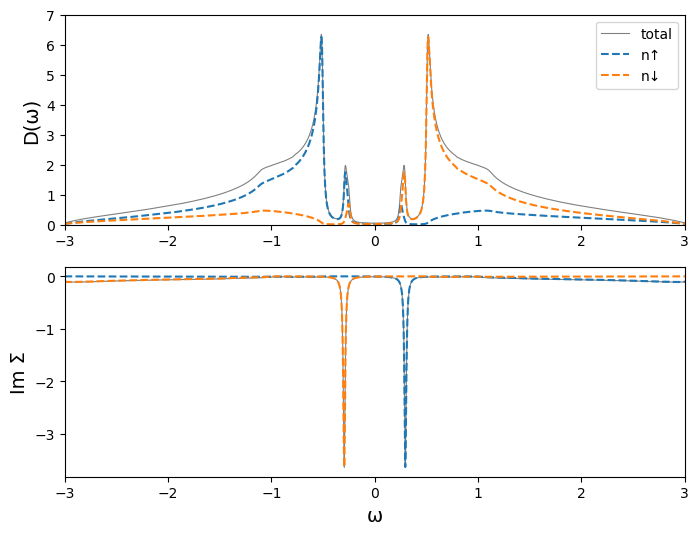

In [7]:
plt.figure(figsize=(8,6))

plt.subplot(2,1,1)
plt.plot(ω,-imag(sum(glocU[:,:,2],dims=2)),color="grey",linewidth=0.8,label="total")
plt.plot(ω,-imag(glocU[:,1,2]),"--",label="n↑")
plt.plot(ω,-imag(glocU[:,2,2]),"--",label="n↓")
plt.xlim(-3,3)
plt.ylim(0,7)
plt.ylabel("D(ω)",fontsize=14)
plt.legend()

plt.subplot(2,1,2)
plt.plot(ω,imag(sum(ΣrU[:,:,2],dims=2)),color="grey",linewidth=0.8)
plt.plot(ω,imag(ΣrU[:,1,2]),"--")
plt.plot(ω,imag(ΣrU[:,2,2]),"--")
plt.xlim(-3,3)
plt.ylabel("Im Σ",fontsize=14)
plt.xlabel("ω",fontsize=14)


plt.show()
plt.savefig("dosupdown_OF_AF.pdf",format="pdf")

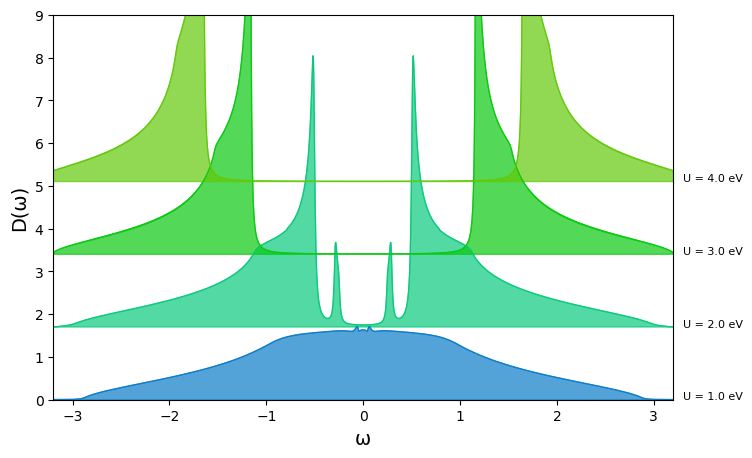

In [8]:
plt.figure(figsize=(8,5))
color = ["#0A7CC9","#0AC97C","#0AC910","#63C90A"]
dashtype = ["-","--","-.",":"]
for (iU,U) in enumerate(Us)
    plt.plot(ω,-imag(sum(glocU[:,:,iU],dims=2)) .+ 1.7*(iU - 1),color=color[iU],linewidth=0.8)
    plt.text(3.3,(iU-1)*1.7,"U = $U eV",fontsize=8)
    plt.fill_between(ω,vec(-imag(sum(glocU[:,:,iU],dims=2)).+ (iU-1)*1.7),(iU-1)*1.7,alpha=0.7,color=color[iU])
end
plt.xlim(-3.2,3.2)
plt.ylim(0,9)
plt.xlabel("ω",fontsize=14)
plt.ylabel("D(ω)",fontsize=14)

plt.show()

plt.savefig("evolUDOS_OF_AF.pdf",format="pdf")

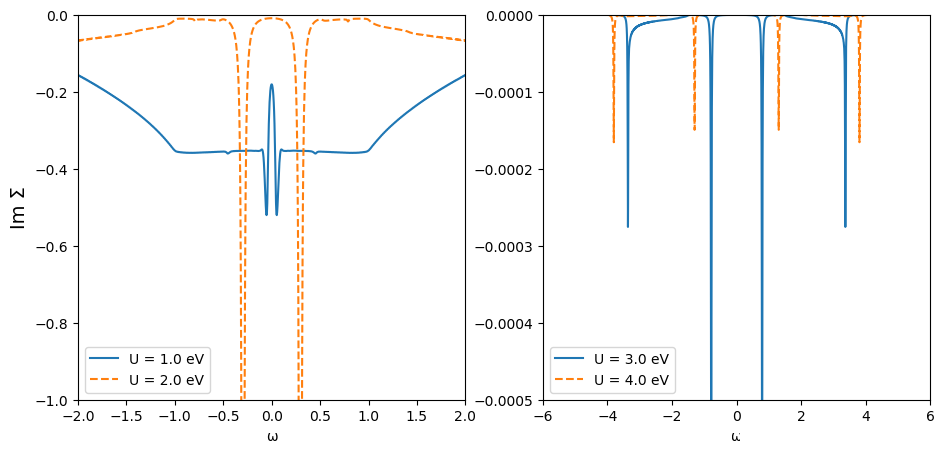

In [9]:
plt.figure(figsize=(11,5))

plt.subplot(1,2,1)
plt.plot(ω,imag(sum(ΣrU[:,:,1],dims=2)),label="U = 1.0 eV")
plt.plot(ω,imag(sum(ΣrU[:,:,2],dims=2)),"--",label="U = 2.0 eV")
plt.xlim(-2,2)
plt.ylim(-1,0)
plt.ylabel("Im Σ",fontsize=14)
plt.xlabel("ω")
plt.legend()

plt.subplot(1,2,2)
plt.plot(ω,imag(sum(ΣrU[:,:,3],dims=2)),label="U = 3.0 eV")
plt.plot(ω,imag(sum(ΣrU[:,:,4],dims=2)),"--",label="U = 4.0 eV")
plt.xlim(-6,6)
plt.ylim(-0.0005,0)
plt.xlabel("ω")
plt.legend()

plt.show()
plt.savefig("evolUΣ_OF_AF.pdf",format="pdf")

In [10]:
U = 2.0
Ts = [100., 1000., 3000., 4000., 5000.,]
Ts = convert(Array{Float64},Ts)

PT = zeros(Float64,Nd,Nd,length(Ts))
glocT = zeros(ComplexF64,nω,2,length(Ts))
ΣrT = zeros(ComplexF64,nω,2,length(Ts))
magnetT = zeros(Float64,length(Ts))

for (iT,T) in enumerate(Ts)
    _,_,PT[:,:,iT],glocT[:,:,iT],
    ΣrT[:,:,iT],magnetT[iT] = OF_solver(ω,D0ω,Nd,nωn,nω,U,T,zeroplus,tol,mix,itermax)
end

Done for U = 2.0 eV and T = 100.0 K
Done for U = 2.0 eV and T = 1000.0 K
Done for U = 2.0 eV and T = 3000.0 K
Done for U = 2.0 eV and T = 4000.0 K
Done for U = 2.0 eV and T = 5000.0 K


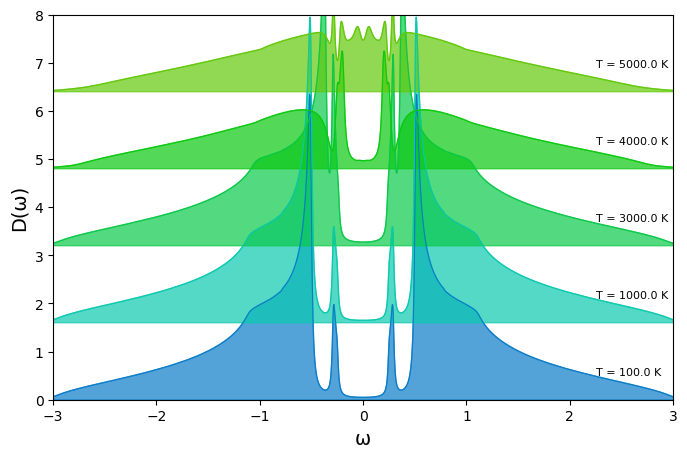

In [11]:
plt.figure(figsize=(8,5))
color = ["#0A7CC9", "#0AC9AF", "#0AC94A","#0AC910","#63C90A"]
dashtype = ["-","--","-.",":"]
for (iT,T) in enumerate(Ts)
    plt.plot(ω,-imag(sum(glocT[:,:,iT],dims=2)) .+ 1.6*(iT - 1),color=color[iT],linewidth=0.8)
    plt.text(2.25,(iT-1)*1.6 + 0.5,"T = $T K",fontsize=8)
    plt.fill_between(ω,vec(-imag(sum(glocT[:,:,iT],dims=2)).+ (iT-1)*1.6),(iT-1)*1.6,alpha=0.7,color=color[iT])
end
plt.xlim(-3.0,3.0)
plt.ylim(0,8)
plt.xlabel("ω",fontsize=14)
plt.ylabel("D(ω)",fontsize=14)

plt.show()

plt.savefig("evolTDOS_OF_AF.pdf",format="pdf")

In [24]:
dx,_ = QuadGK.gauss(Nd)
fig = plt.figure()  
ax = fig.add_subplot(111, projection="3d")  
surf(dx,dx,PT[:,:,5])
ax.set_zlim(-,0.2)

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/mgaffar/.julia/packages/PyCall/ttONZ/src/pyfncall.jl:44 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'RuntimeError'>
RuntimeError('Julia exception: MethodError: no method matching iterate(::typeof(-))\nClosest candidates are:\n  iterate(!Matched::Core.SimpleVector) at essentials.jl:589\n  iterate(!Matched::Core.SimpleVector, !Matched::Any) at essentials.jl:589\n  iterate(!Matched::ExponentialBackOff) at error.jl:171\n  ...\nStacktrace:\n [1] jlwrap_iterator(::Function) at /home/mgaffar/.julia/packages/PyCall/ttONZ/src/pyiterator.jl:150\n [2] pyjlwrap_getiter(::Ptr{PyCall.PyObject_struct}) at /home/mgaffar/.julia/packages/PyCall/ttONZ/src/pyiterator.jl:131\n [3] macro expansion at /home/mgaffar/.julia/packages/PyCall/ttONZ/src/exception.jl:81 [inlined]\n [4] __pycall!(::PyCall.PyObject, ::Ptr{PyCall.PyObject_struct}, ::PyCall.PyObject, ::Ptr{Nothing}) at /home/mgaffar/.julia/packages/PyCall/ttONZ/src/pyfncall.jl:44\n [5] _pycall!(::PyCall.PyObject, ::PyCall.PyObject, ::Tuple{typeof(-),Float64}, ::Int64, ::Ptr{Nothing}) at /home/mgaffar/.julia/packages/PyCall/ttONZ/src/pyfncall.jl:29\n [6] _pycall!(::PyCall.PyObject, ::PyCall.PyObject, ::Tuple{typeof(-),Float64}, ::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}) at /home/mgaffar/.julia/packages/PyCall/ttONZ/src/pyfncall.jl:11\n [7] #call#111(::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::PyCall.PyObject, ::Function, ::Vararg{Any,N} where N) at /home/mgaffar/.julia/packages/PyCall/ttONZ/src/pyfncall.jl:89\n [8] (::PyCall.PyObject)(::Function, ::Vararg{Any,N} where N) at /home/mgaffar/.julia/packages/PyCall/ttONZ/src/pyfncall.jl:89\n [9] top-level scope at In[24]:5\n [10] eval at ./boot.jl:319 [inlined]\n [11] softscope_include_string(::Module, ::String, ::String) at /home/mgaffar/.julia/packages/SoftGlobalScope/cSbw5/src/SoftGlobalScope.jl:218\n [12] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/mgaffar/.julia/packages/IJulia/gI2uA/src/execute_request.jl:67\n [13] #invokelatest#1 at ./essentials.jl:697 [inlined]\n [14] invokelatest at ./essentials.jl:696 [inlined]\n [15] eventloop(::ZMQ.Socket) at /home/mgaffar/.julia/packages/IJulia/gI2uA/src/eventloop.jl:8\n [16] (::getfield(IJulia, Symbol("##15#18")))() at ./task.jl:259')
  File "/home/mgaffar/.julia/conda/3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py", line 741, in set_zlim3d
    bottom = self._validate_converted_limits(bottom, self.convert_zunits)
  File "/home/mgaffar/.julia/conda/3/lib/python3.7/site-packages/matplotlib/axes/_base.py", line 3136, in _validate_converted_limits
    converted_limit = convert(limit)
  File "/home/mgaffar/.julia/conda/3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py", line 157, in convert_zunits
    return self.zaxis.convert_units(z)
  File "/home/mgaffar/.julia/conda/3/lib/python3.7/site-packages/matplotlib/axis.py", line 1521, in convert_units
    if munits.ConversionInterface.is_numlike(x):
  File "/home/mgaffar/.julia/conda/3/lib/python3.7/site-packages/matplotlib/units.py", line 125, in is_numlike
    if iterable(x):
  File "/home/mgaffar/.julia/conda/3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 332, in iterable
    iter(obj)


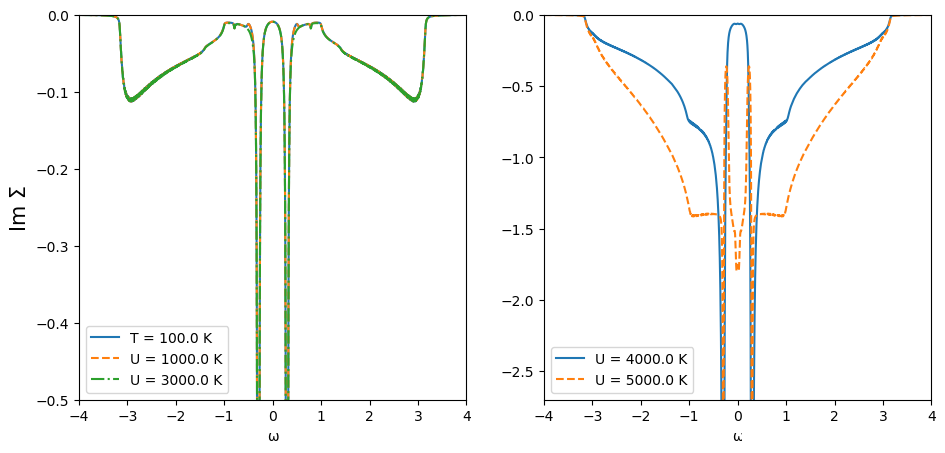

In [12]:
plt.figure(figsize=(11,5))

plt.subplot(1,2,1)
plt.plot(ω,imag(sum(ΣrT[:,:,1],dims=2)),label="T = 100.0 K")
plt.plot(ω,imag(sum(ΣrT[:,:,2],dims=2)),"--",label="U = 1000.0 K")
plt.plot(ω,imag(sum(ΣrT[:,:,3],dims=2)),"-.",label="U = 3000.0 K")
plt.xlim(-4,4)
plt.ylim(-0.5,0)
plt.ylabel("Im Σ",fontsize=15)
plt.xlabel("ω")
plt.legend()

plt.subplot(1,2,2)
plt.plot(ω,imag(sum(ΣrT[:,:,4],dims=2)),label="U = 4000.0 K")
plt.plot(ω,imag(sum(ΣrT[:,:,5],dims=2)),"--",label="U = 5000.0 K")
plt.xlim(-4,4)
plt.ylim(-2.7,0)
plt.xlabel("ω")
plt.legend()

plt.show()
plt.savefig("evolTΣ_OF_AF.pdf",format="pdf")

In [142]:
T = 20.0
Us = range(0.25,length=15,step=0.3)
Us = convert(Array{Float64},Us)

magnetUs = zeros(Float64,length(Us))

for (iU,U) in enumerate(Us)
    _,_,_,_,_,magnetUs[iU] = OF_solver(ω,D0ω,Nd,nωn,nω,U,T,zeroplus,tol,mix,itermax);
end

Done for U = 0.25 eV and T = 20.0 K
Done for U = 0.55 eV and T = 20.0 K
Done for U = 0.85 eV and T = 20.0 K
Done for U = 1.15 eV and T = 20.0 K
Done for U = 1.45 eV and T = 20.0 K
Done for U = 1.75 eV and T = 20.0 K
Done for U = 2.05 eV and T = 20.0 K
Done for U = 2.35 eV and T = 20.0 K
Done for U = 2.65 eV and T = 20.0 K
Done for U = 2.95 eV and T = 20.0 K
Done for U = 3.25 eV and T = 20.0 K
Done for U = 3.55 eV and T = 20.0 K
Done for U = 3.85 eV and T = 20.0 K
Done for U = 4.15 eV and T = 20.0 K
Done for U = 4.45 eV and T = 20.0 K


In [136]:
U = 1.3
Ts = range(0.0,length=20,stop = 5000.)
Ts = convert(Array{Float64},Ts)

magnetTs = zeros(Float64,length(Ts))

for (iT,T) in enumerate(Ts)
    _,_,_,_,_,magnetTs[iT] = OF_solver(ω,D0ω,Nd,nωn,nω,U,T,zeroplus,tol,mix,itermax);
end

Done for U = 1.3 eV and T = 0.0 K
Done for U = 1.3 eV and T = 263.1578947368421 K
Done for U = 1.3 eV and T = 526.3157894736842 K
Done for U = 1.3 eV and T = 789.4736842105264 K
Done for U = 1.3 eV and T = 1052.6315789473683 K
Done for U = 1.3 eV and T = 1315.7894736842106 K
Done for U = 1.3 eV and T = 1578.9473684210527 K
Done for U = 1.3 eV and T = 1842.1052631578948 K
Done for U = 1.3 eV and T = 2105.2631578947367 K
Done for U = 1.3 eV and T = 2368.4210526315787 K
Done for U = 1.3 eV and T = 2631.5789473684213 K
Done for U = 1.3 eV and T = 2894.7368421052633 K
Done for U = 1.3 eV and T = 3157.8947368421054 K
Done for U = 1.3 eV and T = 3421.0526315789475 K
Done for U = 1.3 eV and T = 3684.2105263157896 K
Done for U = 1.3 eV and T = 3947.3684210526317 K
Done for U = 1.3 eV and T = 4210.526315789473 K
Done for U = 1.3 eV and T = 4473.684210526316 K
Done for U = 1.3 eV and T = 4736.8421052631575 K
Done for U = 1.3 eV and T = 5000.0 K


In [164]:
plt.figure(figsize=(11,5))

plt.subplot(1,2,1)
plt.plot(Us,abs.(magnetUs),"-o")
plt.ylabel("Sublattice Magnetization",fontsize=12)
plt.xlabel("U (eV)",fontsize=14)

plt.subplot(1,2,2)
plt.plot(Ts,abs.(magnetTs),"-o")
plt.xlabel("T (K)",fontsize=14)

plt.show()
plt.savefig("magnetization_OF_AF.pdf",format="pdf")

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/mgaffar/.julia/packages/PyCall/ttONZ/src/pyfncall.jl:44 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('x and y must have same first dimension, but have shapes (4,) and (15,)')
  File "/home/mgaffar/.julia/conda/3/lib/python3.7/site-packages/matplotlib/pyplot.py", line 2811, in plot
    is not None else {}), **kwargs)
  File "/home/mgaffar/.julia/conda/3/lib/python3.7/site-packages/matplotlib/__init__.py", line 1810, in inner
    return func(ax, *args, **kwargs)
  File "/home/mgaffar/.julia/conda/3/lib/python3.7/site-packages/matplotlib/axes/_axes.py", line 1611, in plot
    for line in self._get_lines(*args, **kwargs):
  File "/home/mgaffar/.julia/conda/3/lib/python3.7/site-packages/matplotlib/axes/_base.py", line 393, in _grab_next_args
    yield from self._plot_args(this, kwargs)
  File "/home/mgaffar/.julia/conda/3/lib/python3.7/site-packages/matplotlib/axes/_base.py", line 370, in _plot_args
    x, y = self._xy_from_xy(x, y)
  File "/home/mgaffar/.julia/conda/3/lib/python3.7/site-packages/matplotlib/axes/_base.py", line 231, in _xy_from_xy
    "have shapes {} and {}".format(x.shape, y.shape))
